In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen

In [2]:
#Import dataset
files = ['merged_all_2F.csv','merged_all_3F.csv','merged_all_4F.csv']
frames = []
for f in files:
    frames.append(pd.read_csv(f))
df = pd.concat(frames)

In [ ]:
#Temperature formula given in paper
temp_convert = lambda x: (x - 32) * 5/9 + 273.15

In [4]:
#Some Data Transformations
df['time'] = pd.to_datetime(df['time'])
df['Zone Temperature'] = df['Zone Temperature'].apply(temp_convert)
df['Outside Air Temp'] = df['Outside Air Temp'].apply(temp_convert)
df['cooling_thermal_power'] = 1.2041 * 1012.0 * df['Actual Supply Flow'] * (df['Zone Temperature'] - df['Outside Air Temp'])
df['day'] = df['time'].dt.dayofweek
df = df.replace({"day": {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}})
df['hour'] = df['time'].dt.hour

In [5]:
df

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,time,Common Setpoint,Actual Sup Flow SP,Zone Temperature,Actual Supply Flow,energy,Outside Air Temp,Humidity,Zone Temperature Next,Actual Supply Flow Next,Outside Air Temp Next,Humidity Next,energy Next,cooling_thermal_power,day,hour
0,0,0,0.0,2018-01-03 20:57:39+00:00,72.5,330.00,297.150000,318.73,10.109642,293.394444,56.0,75.20,317.06,68.50,56.0,10.113301,1.458613e+06,Wednesday,20
1,1,1,1.0,2018-01-03 21:04:13+00:00,72.5,330.00,297.150000,317.06,10.113301,293.427778,56.0,75.70,314.34,68.25,56.0,10.099466,1.438093e+06,Wednesday,21
2,2,2,2.0,2018-01-03 21:10:44+00:00,72.5,330.00,297.427778,314.34,10.099466,293.288889,56.0,75.70,313.91,68.31,56.0,10.241028,1.585355e+06,Wednesday,21
3,3,3,3.0,2018-01-03 21:17:16+00:00,72.5,330.00,297.427778,313.91,10.241028,293.322222,56.0,75.70,318.31,68.44,57.0,10.187620,1.570436e+06,Wednesday,21
4,4,4,4.0,2018-01-03 21:23:44+00:00,72.5,330.00,297.427778,318.31,10.187620,293.394444,57.0,75.70,316.65,68.81,57.0,10.194055,1.564435e+06,Wednesday,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171931,380,380,NaN,2018-11-20 23:16:55+00:00,72.5,467.29,295.922222,486.62,15.650644,291.311111,49.0,72.99,463.87,65.13,49.0,15.924607,2.734252e+06,Tuesday,23
171932,381,381,NaN,2018-11-20 23:24:01+00:00,72.5,471.92,295.922222,463.87,15.924607,291.555556,49.0,72.99,471.99,64.81,49.0,15.640185,2.468251e+06,Tuesday,23
171933,382,382,NaN,2018-11-20 23:30:54+00:00,72.5,467.16,295.922222,471.99,15.640185,291.377778,49.0,72.99,463.56,64.69,49.0,15.082812,2.613706e+06,Tuesday,23
171934,383,383,NaN,2018-11-20 23:37:51+00:00,72.5,449.29,295.922222,463.56,15.082812,291.311111,49.0,72.99,447.04,64.75,49.0,15.229612,2.604681e+06,Tuesday,23


In [5]:
#Selecting zone and time range
feature_list = ['time','Actual Sup Flow SP','Zone Temperature','Actual Supply Flow','energy','Outside Air Temp','Humidity']
plot_df = df.copy()
#Filter Room ID
plot_df = plot_df[plot_df['Unnamed: 0'] == 0]
#Filter Features
plot_df = plot_df[feature_list]
#Filter Time range
daterange = (plot_df['time'] > '12/1/2018') & (plot_df['time'] <= '1/1/2019')
df_test = plot_df.loc[daterange]

daterange = (plot_df['time'] > '7/7/2017') & (plot_df['time'] <= '1/12/2018')
plot_df = plot_df.loc[daterange]
#Sort by time
plot_df = plot_df.groupby([plot_df['time'].dt.date]).mean()
plot_df = plot_df.sort_values(by='time')
plot_df.head()

,Actual Sup Flow SP,Zone Temperature,Actual Supply Flow,energy,Outside Air Temp,Humidity
time,,,,,,
2017-07-31,469.77,295.888889,472.650000,15.568162,293.500000,60.0
2017-10-11,427.82,295.479630,436.463333,12.551916,293.638889,59.0
2017-10-13,398.16,295.563889,387.500000,11.346948,293.044444,57.0
2017-10-15,624.43,296.694444,625.457500,20.496077,293.638889,59.0
2017-10-17,466.25,295.781944,471.917500,14.451306,298.600000,47.0


In [6]:
#Assuming that multiple readings from the same time are different readings of the day logged at the same time
#Group readings into mean readings per day
df_test.groupby([df_test['time'].dt.date]).mean()
df_test = df_test.sort_values(by='time')
df_test.head()

,time,Actual Sup Flow SP,Zone Temperature,Actual Supply Flow,energy,Outside Air Temp,Humidity
135871,2018-12-01 00:00:37+00:00,341.71,297.627778,350.99,11.307337,289.888889,47.0
41253,2018-12-01 00:00:37+00:00,536.37,296.172222,538.47,17.643290,289.888889,47.0
70862,2018-12-01 00:00:37+00:00,310.00,296.477778,319.55,10.660282,289.888889,47.0
55400,2018-12-01 00:00:37+00:00,310.00,294.888889,313.29,9.975620,289.888889,47.0
106494,2018-12-01 00:00:37+00:00,789.56,295.561111,791.71,25.626479,289.888889,47.0


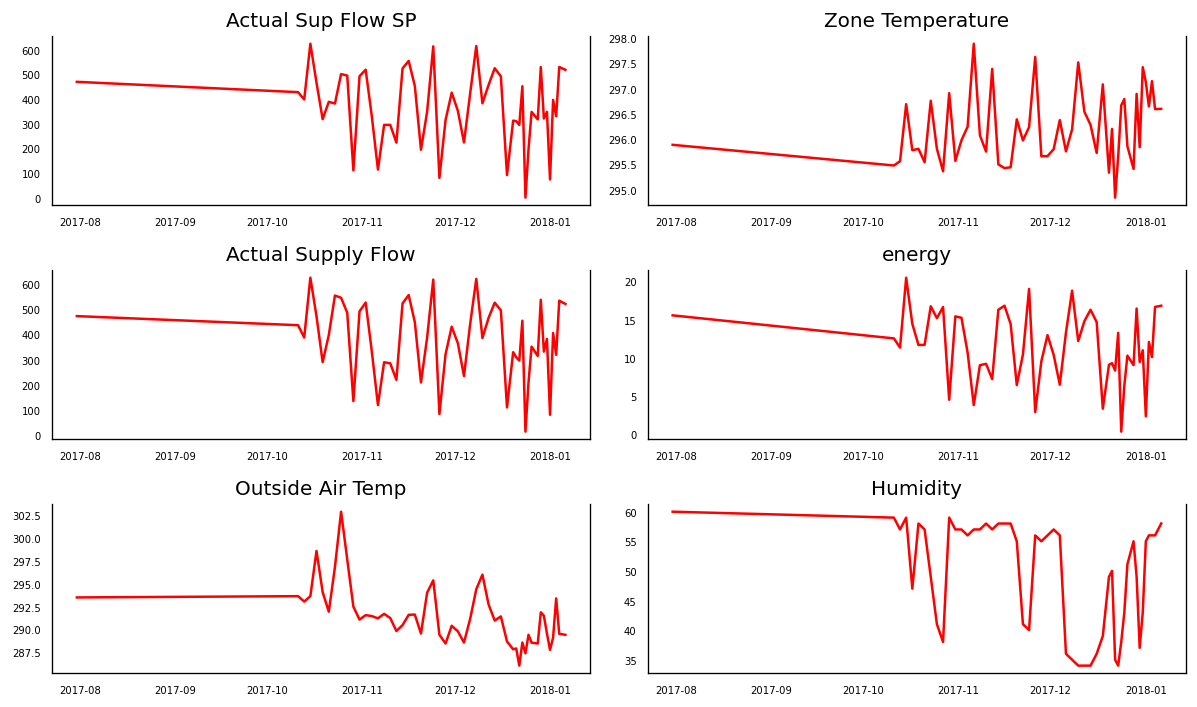

In [9]:
# Plot Features for quick glance of correlation
coluns = ['Actual Sup Flow SP','Zone Temperature','Actual Supply Flow','energy','Outside Air Temp','Humidity']
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = plot_df[[coluns[i]]]
    ax.plot(data, color='red')
    # Decorations
    ax.set_title(coluns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

<AxesSubplot:>

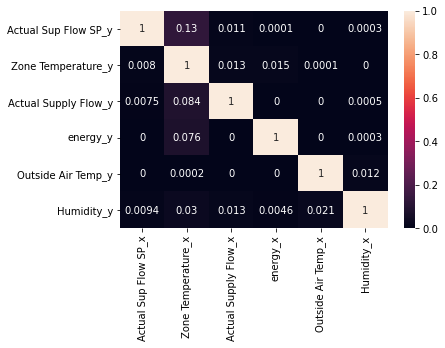

In [10]:
#Check granger causality between features
df = plot_df
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

granger_matrix = grangers_causation_matrix(df, variables = df.columns)
sns.heatmap(granger_matrix, annot=True)

In [11]:
#Check cointegration
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Actual Sup Flow SP ::  182.72    > 83.9383   =>   True
Zone Temperature ::  76.57     > 60.0627   =>   True
Actual Supply Flow ::  31.4      > 40.1749   =>   False
energy ::  16.15     > 24.2761   =>   False
Outside Air Temp ::  3.28      > 12.3212   =>   False
Humidity ::  0.74      > 4.1296    =>   False


In [12]:
#Check ADF
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [13]:
#Differ the features until it is stationary
df_differed = df
for i in range(0):
    df_differed = df_differed.diff().dropna()

In [14]:
#Check if all features are stationary
for name, column in df_differed.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Actual Sup Flow SP" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.6068
 No. Lags Chosen       = 0
 Critical value 1%     = -3.566
 Critical value 5%     = -2.92
 Critical value 10%    = -2.598
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Zone Temperature" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.5686
 No. Lags Chosen       = 7
 Critical value 1%     = -3.589
 Critical value 5%     = -2.93
 Critical value 10%    = -2.603
 => P-Value = 0.0997. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Actual Supply Flow" 
    -----------------------------------------------
 Null Hypothesis: Dat

In [15]:
#Find optimum order
model = VAR(df_differed)
x = model.select_order(maxlags=5)
x.summary()

D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


,AIC,BIC,FPE,HQIC
0,21.14,21.38,1.516e+09,21.23
1,19.38,21.04*,2.653e+08,20.01*
2,19.21*,22.28,2.395e+08*,20.36
3,20.01,24.50,6.576e+08,21.70
4,19.72,25.62,7.614e+08,21.94
5,19.48,26.80,1.407e+09,22.23


In [16]:
#Fit model with above order
model_fitted = model.fit(2)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 25, Jan, 2023
Time:                     12:55:25
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                    22.6642
Nobs:                     50.0000    HQIC:                   20.8173
Log likelihood:          -839.717    FPE:                3.79637e+08
AIC:                      19.6814    Det(Omega_mle):     9.48735e+07
--------------------------------------------------------------------
Results for equation Actual Sup Flow SP
                           coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------
const                    -20692.537157     15189.960441           -1.362           0.173
L1.Actual Sup Flow SP        -0.645757         0.983901           -0.656           0.512
L1.Zone Tempera

In [24]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_differed.values[-lag_order:]
forecast_input

fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_2d')
df_forecast

2


,Actual Sup Flow SP_2d,Zone Temperature_2d,Actual Supply Flow_2d,energy_2d,Outside Air Temp_2d,Humidity_2d
time,,,,,,
2017-11-20,431.912270,295.468694,430.348718,12.618260,290.939539,47.443496
2017-11-22,453.437504,295.970331,466.847509,14.487257,291.514592,43.063580
2017-11-24,304.488300,296.430809,318.254477,9.436060,291.732764,43.131971
2017-11-26,339.922944,296.195089,353.236603,10.839377,291.041208,43.621856
2017-11-28,342.556696,296.329373,350.470224,10.545354,290.734664,46.929164
2017-11-30,336.027828,296.191886,344.664568,10.468227,290.355248,47.551132
2017-12-02,349.479639,296.266495,356.058754,10.741367,290.409122,48.307039
2017-12-04,350.983958,296.205697,358.428840,10.851825,290.504581,47.866763
2017-12-06,354.733067,296.268922,361.063654,10.946524,290.603159,47.963683


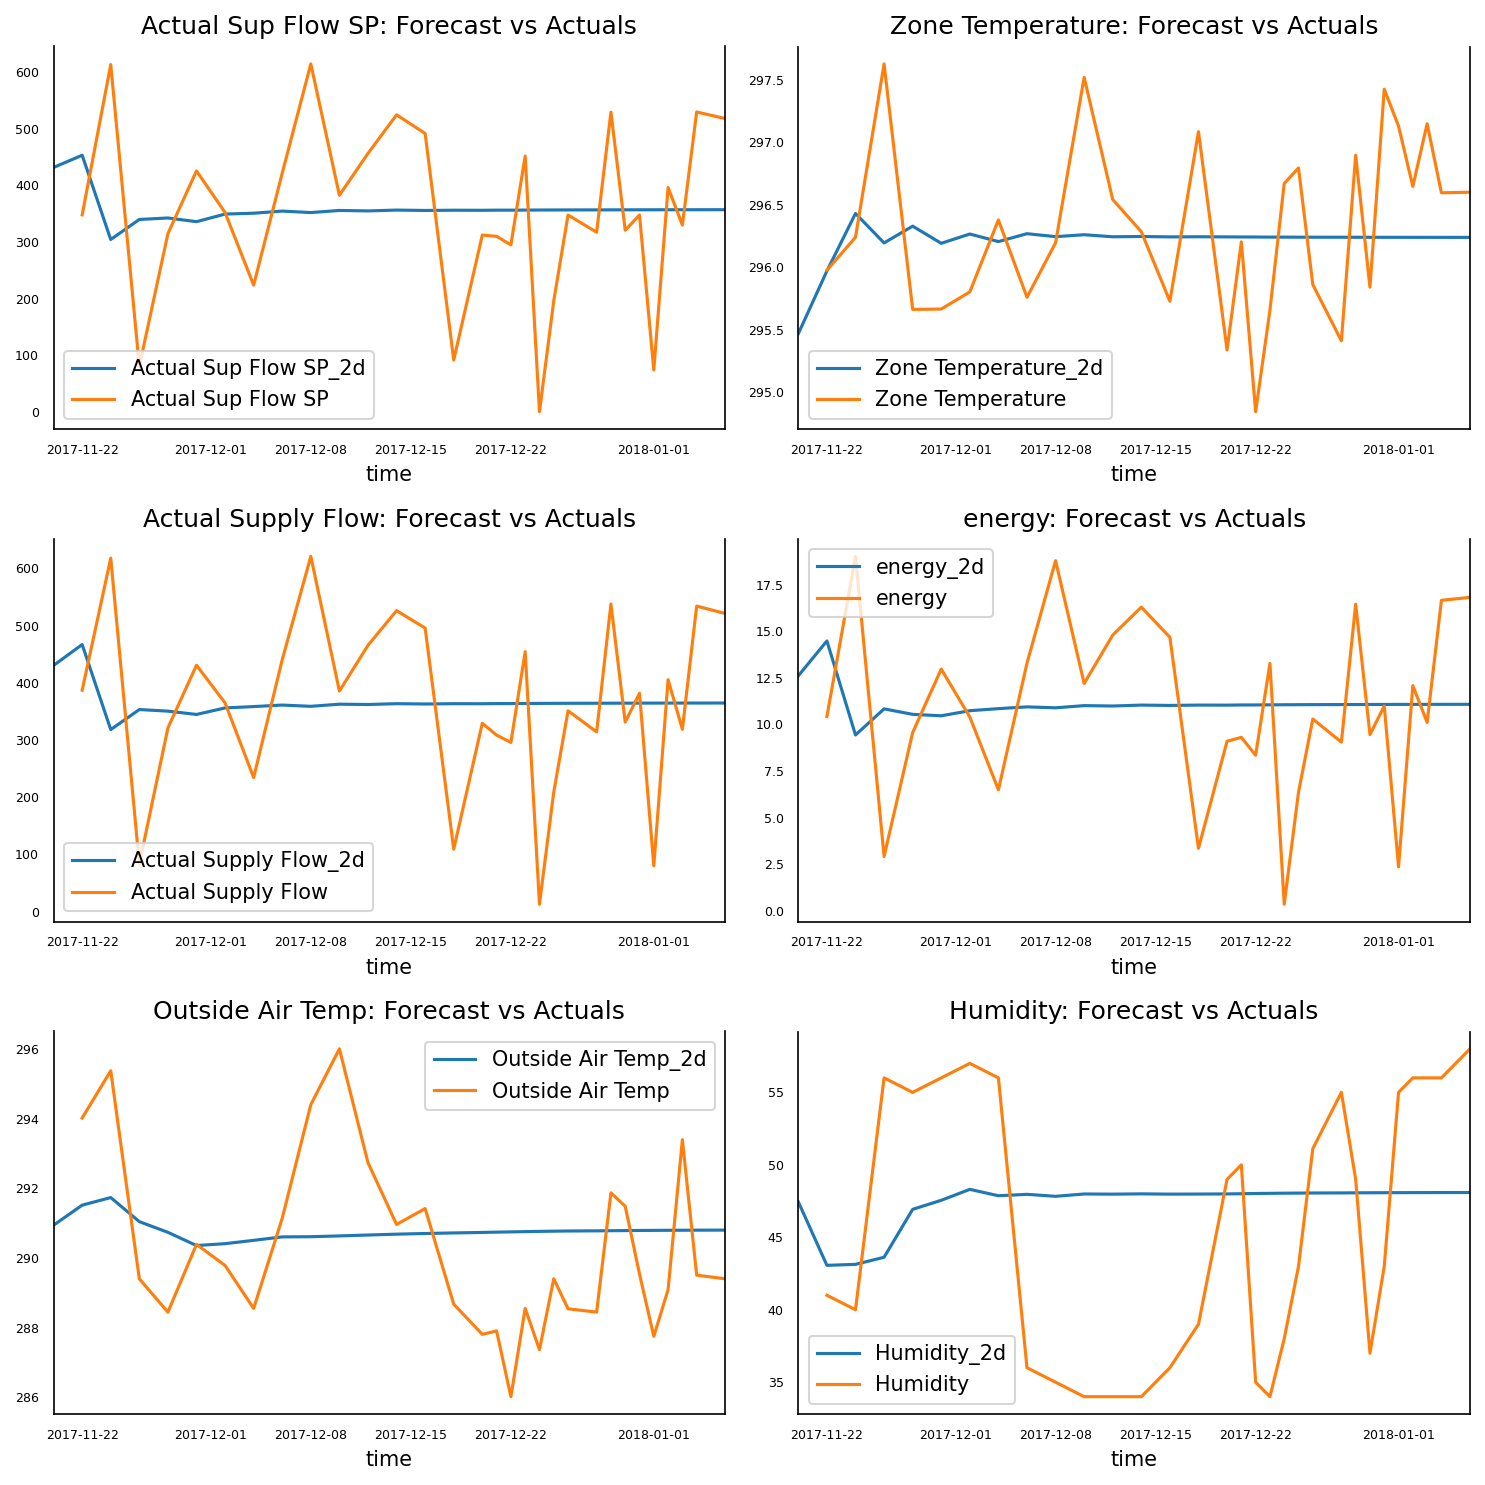

In [43]:
#Forecast and plot
df_results = df_forecast
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_2d'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();